In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import math
%matplotlib inline

# Part 1: A Feature Tracker

## Overview

Implementation ofcorner detector and feature tracker that track features from the image sequence hotel. 

## Data


In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 156MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [ ]:
from numpy.lib.shape_base import get_array_prepare
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    print("Processing image: ",t)
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

def color_to_gray(img_sequence):
  # Converting image sequence to grayscale
  gray_img_sequence=[]
  for i in range(img_sequence.shape[0]):
    gray = cv2.cvtColor(img_sequence[i, :, :, :], cv2.COLOR_BGR2GRAY)
    gray_img_sequence.append(gray)
  return np.array(gray_img_sequence)


# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 
im = color_to_gray(im)


## 1.1 Keypoint Selection


### Code

Key Points shape  (534, 2)


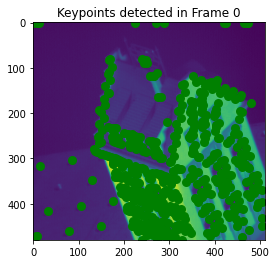

In [ ]:
from numpy.core.memmap import uint8
def Sobel_filter(image, Sobel, width, height): # Calculating Sobel Gradients
  I_d = np.zeros((width, height), np.float32)
  for rows in range(width):
      for cols in range(height):
          # Runing the Sobel kernel for each pixel
          if rows >= 1 or rows <= width-2 and cols >= 1 or cols <= height-2:
              for ind in range(3):
                  for ite in range(3):
                      I_d[rows][cols] += Sobel[ind][ite] * image[rows - ind - 1][cols - ite - 1]
          else:
              I_d[rows][cols] = image[rows][cols]

  return I_d

def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
 
  # Initializing
  w, h = img.shape
  CornerStrengthThreshold = 600000
  
  # Smoothing the image (Optional)
  #img = cv2.GaussianBlur(np.uint8(img),(7, 7),1)

  # Computing image gradients
  SobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  SobelY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
  x_grad = Sobel_filter(img, SobelX, w, h)
  y_grad = Sobel_filter(img, SobelY, w, h)

  for ind1 in range(w):
    for ind2 in range(h):
      if y_grad[ind1][ind2] < 0:
        y_grad[ind1][ind2] *= -1
      if x_grad[ind1][ind2] < 0:
        x_grad[ind1][ind2] *= -1

  # Compute Ix*Ix, Iy*Iy, Ix*Iy
  Ix_Ix = np.square(x_grad)
  Iy_Iy = np.square(y_grad)
  Ix_Iy = np.multiply(x_grad , y_grad)

  #print(np.min(Ix_Iy), np.max(Ix_Iy))
  #Smooth computed gradients
  Sigma = 1.4
  kernelsize = (3, 3)
  Ix_Ix = cv2.GaussianBlur(Ix_Ix, kernelsize, Sigma)
  Iy_Iy = cv2.GaussianBlur(Iy_Iy, kernelsize, Sigma)
  Ix_Iy = cv2.GaussianBlur(Ix_Iy, kernelsize, Sigma)
 

  # Compute Harris Corner Score
  alpha = 0.06
  R = np.zeros((w, h), np.float32)
  # For every pixel find the corner strength
  for row in range(w):
      for col in range(h):
          M_bar = np.array([[Ix_Ix[row][col], Ix_Iy[row][col]], [Ix_Ix[row][col], Iy_Iy[row][col]]])
          R[row][col] = np.linalg.det(M_bar) - (alpha * np.square(np.trace(M_bar)))

  # print("R range", np.min(R), np.max(R))
  # print(R.shape)

  CornerPoints=[]

  for row in range(w):
    for col in range(h):
        if R[row][col] > CornerStrengthThreshold:
          # print(R[row][col])
          max = R[row][col]

          # Local non-maxima suppression
          flag = False
          for nrow in range(5):
              for ncol in range(5):
                  if row + nrow - 2 < w and col + ncol - 2 < h:
                      if R[row + nrow - 2][col + ncol - 2] > max:
                          flag = True
                          break

          if not flag:
              CornerPoints.append((row, col))

  CornerPoints = np.array(CornerPoints)
  CornerPoints[:, [1, 0]] = CornerPoints[:, [0, 1]]

  return CornerPoints

# compute keypoints in the first sequence
tau = 0.08 
key_pts = getKeypoints(im[0], tau)
#add plots for the write-up
# #  
print("Key Points shape ", key_pts.shape)
plt.scatter(key_pts[:,0],  key_pts[:,1], color ='g', linewidth=3)
plt.imshow(im[0].astype(np.uint8))
plt.title("Keypoints detected in Frame 0")
plt.show()



1) Implementation of getKeypoints():
For getting the keypoints, the following steps were followed


1.   The image was passed through a Gaussian smoothing filter.
2.   The image's gradient in x and y direction were computed using the Sobel kernel.
3. The gradients obtained in step two were normalized and the cross gradients IxIx, IxIy and IyIy were computed. 
4. The cross gradients were blurred using Gausian filter of size 3 by 3.
5. For every pixel in the image, using the cross gradients, the Harris Corner score was calculated. 
6. The scores were thresholded with tau = 0.06 and local non maxima supression was done in a window size of 5 by 5. 
7. The non-zero scores were extracted into a matrix as the keypoints which are plotted above.



## 1.2 Feature Tracking 

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 
Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.



### Code

In [ ]:
def get_A(i, j, w, IxIx, IyIy, IxIy):
  Ix_Ix = np.sum(IxIx[i-w : i+w , j-w : j+w])
  Iy_Iy = np.sum(IyIy[i-w : i+w , j-w : j+w])
  Ix_Iy = np.sum(IxIy[i-w : i+w , j-w : j+w])
  A = np.array([[Ix_Ix, Ix_Iy], [Ix_Iy, Iy_Iy]])
  return A

def get_b(i, j, w, IxIt, IyIt):
  Ix_It = np.sum(IxIt[i-w : i+w , j-w : j+w])
  Iy_It = np.sum(IyIt[i-w : i+w , j-w : j+w])
  b = -1 * np.array([[Ix_It], [Iy_It]])
  return b

def get_U(x_idx, y_idx, window, keypt_size, IxIx, IyIy, IxIy, IxIt, IyIt):
  
  if x_idx >= window and x_idx <= keypt_size -window and y_idx >= window and y_idx <= keypt_size -window:
    
    A = get_A(x_idx, y_idx, window, IxIx, IyIy, IxIy)
    b = get_b(x_idx, y_idx, window, IxIt, IyIt)
    U = np.matmul(np.linalg.pinv(A), b)
    u = float(U[0, :])
    v = float(U[1, :])
    x_update = np.int32(x_idx + u)
    y_update = np.int32(y_idx + v)
    return x_update, y_update

  else:
    return x_idx, y_idx


def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  

  # Finding derivatives
  
  width, height = im1.shape
  im1 = np.array(im1)
  im2 = np.array(im2)

  Ix = cv2.Sobel(im1, -1, 1, 0, ksize=3)
  Iy = cv2.Sobel(im1, -1, 0, 1, ksize=3)

  It = np.subtract(im1, im2)
  IxIx = np.multiply(Ix, Ix)
  IyIy = np.multiply(Iy, Iy)
  IxIy = np.multiply(Ix, Iy)

  IxIt = -1* np.multiply(Ix, It)
  IyIt = -1* np.multiply(Iy, It)

  w = int(ws/2)
  u_list=[]
  v_list=[]
  keypt_size = len(x)
  niter = 15

  for i in range(keypt_size) :
    x_idx = int(x[i])
    y_idx = int(y[i])
    u = np.zeros(niter)
    v = np.zeros(niter)
    for k in range(niter):
      u[k], v[k] = get_U(x_idx, y_idx, w, keypt_size, IxIx, IyIy, IxIy, IxIt, IyIt)
      x_idx = int(u[k])
      y_idx = int(v[k])

    u_list.append(int(u[-1]))
    v_list.append(int(v[-1]))


  print("lengths of u and v ", len(u_list), len(v_list))
  status = np.zeros(im1.shape)
  # for i in range(width):
  #   for j in range(height):
  #     if 
  return u_list, v_list
# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
ws = 15
tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

# # plot your results
# 
tracked_pts = np.array(tracked_pts)
def plot1(tracked_pts, im):
  plt.figure(figsize = (15,20))
  plt.subplot(1,2,1)
  plt.title("Tracked features on img0")
  for i in range(tracked_pts.shape[1]):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[0], cmap='gray')
  plt.subplot(1,2,2)
  plt.title("Tracked features on img50")
  for i in range(tracked_pts.shape[1]):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[50], cmap='gray')
  plt.show()

def plot2(tracked_pts, im):
  #print(tracked_pts.shape)
  plt.figure(figsize = (15,20))
  plt.subplot(1,2,1)
  plt.title("20 Tracked features on img0")
  for i in range(10,tracked_pts.shape[1], 30):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[0], cmap='gray')
  plt.subplot(1,2,2)
  plt.title("20 Tracked features on img50")
  for i in range(10,tracked_pts.shape[1], 30):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[50], cmap='gray')

def plot3(tracked_pts, im):
  #print(tracked_pts.shape)
  plt.figure(figsize = (15,20))
  plt.subplot(1,2,1)
  plt.title("Tracked features on img0")
  for i in range(tracked_pts.shape[1]):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[0], cmap='gray')
  plt.subplot(1,2,2)
  plt.title("Tracked features on img50")
  for i in range(tracked_pts.shape[1]):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[50], cmap='gray')

plot1(tracked_pts, im)
plot2(tracked_pts, im)
#plot3(tracked_pts, im)

# Part 2: Shape Alignment

## Overview
A function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$.



## Data


In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 54.1MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [ ]:
from skimage import color
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim



## Code

In [ ]:
# Reference used: https://nbviewer.org/github/niosus/notebooks/blob/master/icp.ipynb
import math

def plot_img(points, img):
  image_new = np.zeros(img.shape)
  for i in range(points.shape[1]):
    if points[0][i] < img.shape[1] and points[1][i] < img.shape[0]:
      image_new[int(points[1][i])][int(points[0][i])] = 1
  return image_new
  
class correlation():
  def __init__(self, data_1, data_2):
    self.data_1 = data_1
    self.data_2 = data_2
    self.P_centered = []
    self.Q_centered = []
    self.cores = []

    self.centered_data()

  def find_mean(self):
    self.data_1_mean = np.zeros((2,1))
    self.data_2_mean = np.zeros((2,1))
    for i in range(self.data_1.shape[1]):
      self.data_1_mean[0][0] += self.data_1[0][i] / self.data_1.shape[1]
      self.data_1_mean[1][0] += self.data_1[1][i] / self.data_1.shape[1]
    for i in range(self.data_2.shape[1]):
      self.data_2_mean[0][0] += self.data_2[0][i] / self.data_2.shape[1]
      self.data_2_mean[1][0] += self.data_2[1][i] / self.data_2.shape[1]
    return np.array(self.data_1_mean), np.array(self.data_2_mean)

  def centered_data(self):
    Pmean, Qmean = self.find_mean()
    self.P_centered = self.data_1 - Pmean
    self.Q_centered = self.data_2 - Qmean

  def find_closest_data(self):
    min_index = []
    # min_dis = []
    idx = []
    for i in range(len(self.P_centered[0])):
      target_data = []
      target_data.append(self.P_centered[0][i])
      target_data.append(self.P_centered[1][i])
      dis = 99999.0
      index = -1
      for j in range(len(self.Q_centered[0])):
        ref_data = []
        ref_data.append(self.Q_centered[0][j])
        ref_data.append(self.Q_centered[1][j])
        distance = math.sqrt(((ref_data[0]-target_data[0])**2)+((ref_data[1]-target_data[1])**2))
        if distance < dis:
          index = j
          dis = distance
      idx.append(i)
      min_index.append(index)
    self.cores.append(idx)
    self.cores.append(min_index)
    return np.array(self.cores)

  def find_crosscov(self):  #Finding cross covariance  matrix and mean values of the matched points
    self.cross = np.zeros((2,2))
    for i in range(len(self.cores[0])):
      self.cross[0][0] += self.P_centered[0][self.cores[0][i]]*self.Q_centered[0][self.cores[1][i]]
      self.cross[1][0] += self.P_centered[0][self.cores[0][i]]*self.Q_centered[1][self.cores[1][i]]
      self.cross[0][1] += self.P_centered[1][self.cores[0][i]]*self.Q_centered[0][self.cores[1][i]]
      self.cross[1][1] += self.P_centered[1][self.cores[0][i]]*self.Q_centered[1][self.cores[1][i]]
    
    self.cross = self.cross / len(self.P_centered[0])
    
    return self.cross


In [ ]:
class gradient_img():   
  def __init__(self, img):
    self.img = img
    self.x_grad = np.zeros(img.shape)
    self.y_grad = np.zeros(img.shape)
    self.find_gradient(img)

  def find_gradient(self, img):
    # Finding gradient between frames
    for i in range(1,img.shape[0]):
      for j in range(1,img.shape[1]):
        self.x_grad[i][j] = self.img[i][j] - self.img[i][j-1]
        self.y_grad[i][j] = self.img[i][j] - self.img[i-1][j]

def indices2list(img):
  # Finding valid indices
  x_location = []
  y_location = []
  threshold = 1
  grad_img = gradient_img(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if abs(grad_img.x_grad[i][j]) >= threshold or abs(grad_img.y_grad[i][j]) >= threshold:
        x_location.append(i)
        y_location.append(j)
  location = []
  location.append(y_location)
  location.append(x_location)
  return location

def find_center(points):
  total_x = np.sum(points[0,:])
  total_y = np.sum(points[1,:])
  scaling_x = np.var(points[0,:])
  scaling_y = np.var(points[1, :])
  return total_x/len(points[0]), total_y/len(points[1]), math.sqrt(scaling_x), math.sqrt(scaling_y)

def initialize_data(data_1, data_2):
  #translate and scale data_1 to data_2
  data_1_x = data_1[0,:]
  data_1_y = data_1[1,:]
  data_2_x = data_2[0,:]
  data_2_y = data_2[1,:]
  c1_x, c1_y, var1_x, var1_y = find_center(data_1)
  c2_x, c2_y, var2_x, var2_y = find_center(data_2)
  move_x = c1_x - c2_x
  move_y = c1_y - c2_y

  if abs((var1_x/var2_x) - (var1_y/var2_y)) > 1: 
    new_data_1_x = data_1_x - move_x  
    new_data_1_y = data_1_y - move_y  
  else:
    new_data_1_x = data_1_x*(var2_x/var1_x) - move_x  
    new_data_1_y = data_1_y*(var2_y/var1_y) - move_y  
  newdata = []
  newdata.append(new_data_1_x)
  newdata.append(new_data_1_y)
  return np.array(newdata)

class shape_align():
  def __init__(self, indices1, indices2, im1, im2, iternum):
    self.data_1 = np.array(indices1)
    self.data_2 = np.array(indices2)
    self.img1 = im1
    self.img2 = im2
    self.iternum = iternum

  def Squared_distance(self, point1, point2):
    #ssd
    return math.sqrt(((point1[0]-point2[0])**2) + ((point1[1]-point2[1])**2))

  def find_nearest_neighbor(self, datalocation):
    corres = []
    data_1location = []
    data_2location = []
    dist_tracker = []
    for i in range(datalocation.shape[1]):
      data_1location.append(i)
      minDistance = 99999
      idx = -1
      target = datalocation[:,i]
      for j in range(self.data_2.shape[1]):
        refer = self.data_2[:,j]
        distance = self.Squared_distance(target, refer)
        if distance < minDistance:
          minDistance = distance
          idx = j
      data_2location.append(idx)
      dist_tracker.append(minDistance)
    corres.append(data_1location)
    corres.append(data_2location)
    corres.append(dist_tracker)
    corres = np.array(corres)
    return corres

  def find_T(self, corres):
    T = []
    for i in range(corres.shape[1]):
      temp1 = [self.data_1[0][int(corres[0][i])], self.data_1[1][int(corres[0][i])], 0, 0, 1, 0]
      temp2 = [0, 0, self.data_1[0][int(corres[0][i])], self.data_1[1][int(corres[0][i])], 0, 1]
      T.append(temp1)
      T.append(temp2)
    return np.array(T)

  def find_b(self, corres):
    b = []
    for i in range(corres.shape[1]):
      b.append(self.data_2[0][int(corres[1][i])])
      b.append(self.data_2[1][int(corres[1][i])])
    return np.transpose(np.array(b))

  def get_Vector(self, T, b):
    A = np.transpose(T) @ T  
    v = np.transpose(T) @ b
    B = np.linalg.pinv(T)
    motion = np.dot(B, b)
    print(motion)

    R = np.zeros((2,2))
    R[0][0] = motion[0]
    R[0][1] = motion[1]
    R[1][0] = motion[2]
    R[1][1] = motion[3]

    t = np.zeros((2,1))
    t[0][0] = motion[4]
    t[1][0] = motion[5]

    full_matrix = []
    full_matrix.append([R[0][0], R[0][1], t[0][0]])
    full_matrix.append([R[1][0], R[1][1], t[1][0]])
    full_matrix.append([0, 0, 1])
    return R, t, full_matrix
  
  def update_Loc(self, edge, R, t):
    newedge = np.zeros(edge.shape)
    for i in range(edge.shape[1]):
      target = [ [edge[0][i]],[edge[1][i]] ]
      update = np.dot(R, target) + t
      newedge[0][i] = np.round(update[0][0])
      newedge[1][i] = np.round(update[1][0])
    print(newedge.shape)
    return np.array(newedge)

  def match_shape(self):
    matrix_tracker = []
    current_location = self.data_1

    for iter in range(self.iternum):
      self.plot_corners(current_location, self.data_2, self.img1, self.img2)
      print("Running iteration:", iter)
      ## find nearest neighbors 
      correspond = self.find_nearest_neighbor(current_location)
      ## Solve T and b matrix for R and t
      T = self.find_T(correspond)
      b = self.find_b(correspond)
      R, t, fullMatrix = self.get_Vector(T, b)
      print("R:", R)
      print("t:", t)
      matrix_tracker.append(fullMatrix)  ## keep track of R and t
      # Updating location from image 1
      current_location = self.update_Loc(current_location, R, t)
      current_location = np.round(current_location)
    self.plot_corners(current_location, self.data_2, self.img1, self.img2)  
    return current_location, np.array(matrix_tracker)
      
  def plot_corners(self, indices1, indices2, im1, im2):
    plt.figure()
    plt.scatter(indices1[0,:], indices1[1,:], color = 'r')
    plt.scatter(indices2[0,:], indices2[1,:], color = 'b')
    plt.imshow(im2.astype(np.uint8), cmap='gray')
    plt.show()

def align_shape(im1, im2):
  '''
  im1: input edge image 1
  im2: input edge image 2
  Output: transformation T [3] x [3]
  '''

  indices1 = np.array(indices2list(im1))
  indices2 = np.array(indices2list(im2))
  indices1 = initialize_data(indices1, indices2)
  print("Feature sizes of the images:",indices1.shape, indices2.shape)

  iternum = 50
  track_matrix = []
  err = []
  print("Shape alignment iteration=", iternum)
  for iter in range(iternum):
    # print("Running iteration:", iter)
    corr = correlation(indices1, indices2)
    cores = corr.find_closest_data()
    corre_matrix = corr.find_crosscov()

    U, S, V = np.linalg.svd(corre_matrix)
    R = np.dot(U,V)
    T = corr.data_2_mean - np.dot(R, corr.data_1_mean)
    indices1 = np.dot(R, indices1)+T

    #R matrix
    feature1 = [R[0][0], R[0][1], T[0][0]]
    feature2 = [R[1][0], R[1][1], T[1][0]]
    feature3 = [0, 0, 1]
    final_matrix =[]
    final_matrix.append(feature1)
    final_matrix.append(feature2)
    final_matrix.append(feature3)
    track_matrix.append(final_matrix)

  plt.figure()
  plt.scatter(indices1[0,:], indices1[1,:], color = 'r')
  plt.scatter(indices2[0,:], indices2[1,:], color = 'b')
  plt.imshow(im2.astype(np.uint8), cmap='gray')
  plt.show()

  # Evaluating error
  new_aligned_img = plot_img(indices1, im1)
  err.append(evalAlignment(new_aligned_img, im2))
  
  return np.array(track_matrix), err

Feature sizes of the images: (2, 1503) (2, 1518)
Shape alignment iteration= 50


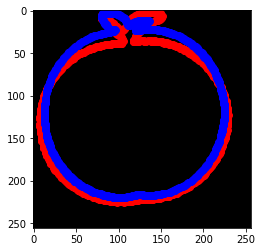

Error value:  [3.074359080400374]
Feature sizes of the images: (2, 1115) (2, 1378)
Shape alignment iteration= 50


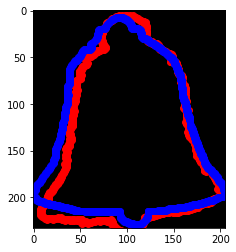

Error value:  [2.9321780001724127]
Feature sizes of the images: (2, 675) (2, 791)
Shape alignment iteration= 50


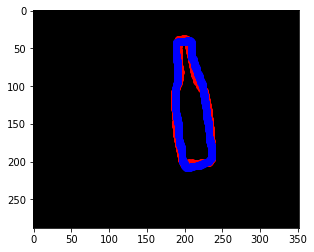

Error value:  [0.9809997550041264]
Feature sizes of the images: (2, 1115) (2, 1201)
Shape alignment iteration= 50


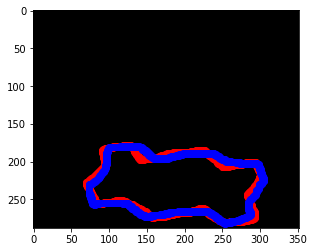

Error value:  [1.5450962397934742]
Feature sizes of the images: (2, 941) (2, 1065)
Shape alignment iteration= 50


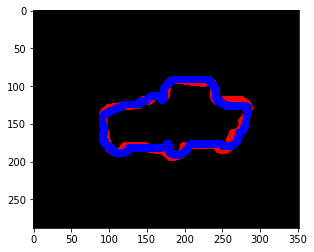

Error value:  [1.305129138541739]
Feature sizes of the images: (2, 864) (2, 857)
Shape alignment iteration= 50


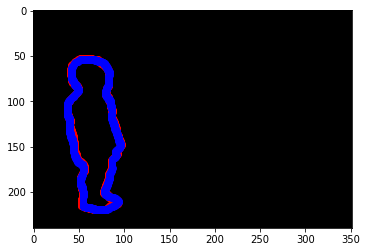

Error value:  [0.4758848959384164]
Feature sizes of the images: (2, 2866) (2, 2754)
Shape alignment iteration= 50


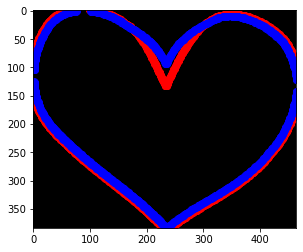

Error value:  [3.6205312446937405]
Feature sizes of the images: (2, 1594) (2, 1625)
Shape alignment iteration= 50


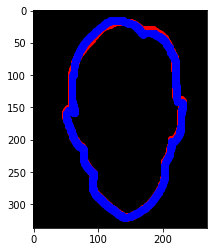

Error value:  [0.651000637311299]


In [ ]:
from skimage import color
imgPath = '/content/part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

sub_objList = ['apple', 'bell', 'bottle', 'brick', 'car', 'children', 'Heart', 'face']

numObj = len(objList)
## Run shape alignment

for img_name in sub_objList:
  img1 = cv2.imread(imgPath+img_name+"_1.png")
  img2 = cv2.imread(imgPath+img_name+"_2.png")
  img1 = color.rgb2gray(img1)
  img2 = color.rgb2gray(img2)
  T, err = align_shape(img1, img2)
  print("Error value: ", err)




1. The mean and variance of the two images is found for initializing the rotation and scaling matrix. For every point in image 1, the nearest nonzero coordinate is found in image 2. A cross correlation matrix with the two keypoints of the two images is found and the singular value decomposition is done of the cross correlation matrix. R, the rotation matrix, is found from the decomposition, and T the translation matrix, is calculated as Pmean times R subtracted from Qmean(P and Q are the initial keypoints of the two images repectively).  Then the keypoints of P are updated using the current R and T. This process is repeated for the given iterations till the error is small. The error is found from the norm of Qmean and R.Pmean. The iterations used in the code are 50 per image..

2. Final error for the alignment is printed with the images above.

3. Runtime: For the bell image of size 216 by 216 the program takes 2 minutes to compute. 

# Part 3: Object Instance Recognition

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. 

## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 19.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 94.0MB/s]


## Code

Shape of the two images: (480, 355, 3) (683, 1024, 3)
Found 30 keypoints with threshold = 127
Shape of the two images: (480, 355, 3) (683, 1024, 3)
Found 30 keypoints with ratio threshold = 0.8


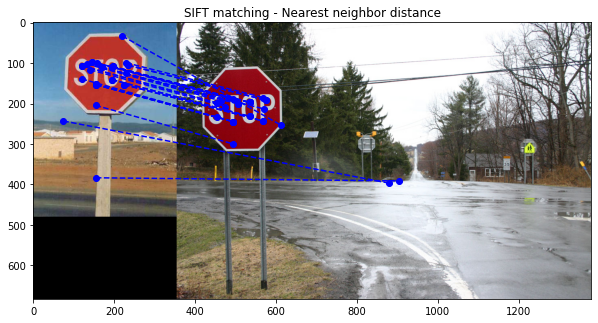

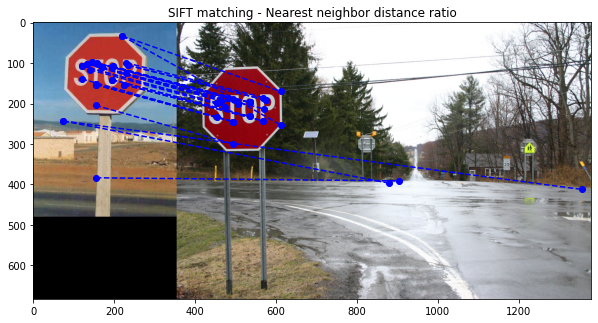

In [ ]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

'''
SIFT descriptor:
16*16 window -> 4*4 grid(cell) -> compute the histogram and orientation of each cell
4*4*8 = 128 description of a 16*16 window 

'''
Frame1 = np.array(Frame1)
Descriptor1 = np.array(Descriptor1)
Frame2 = np.array(Frame2)
Descriptor2 = np.array(Descriptor2)

'''
Frame 1 shape 4*558 [0]
Desript1 shape 128*558 [0]
'''

## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2
class SIFT():
  def __init__(self, data_1, data_2, descrip1, descrip2):
    self.data_1 = np.array(data_1)
    self.data_2 = np.array(data_2)
    self.descript1 = np.array(descrip1)
    self.descript2 = np.array(descrip2)
    self.correspond = []
  
  def ssd(self, script1, script2):
    ## script1, script2 is 128*1 data
    scriptsize = 128
    total = 0
    for i in range(scriptsize):
      total += (int(script1[i]) - int(script2[i]))**2
      if total > 999999999:
        return 99999999999
    return math.sqrt(total)

  def find_min_correspondance(self):
    feature1_num = self.descript1.shape[1]
    feature2_num = self.descript2.shape[1]
    data_1_idx = []
    data_2_idx = []
    corres_distance = []
    for i in range(feature1_num):
      target = self.descript1[:, i]
      data_1_idx.append(i)
      minDistance = 9999999
      idx = -1
      for j in range(feature2_num):
        refer = self.descript2[:,j]
        distance = self.ssd(target, refer)
        if distance < minDistance:
          idx = j
          minDistance = distance
      data_2_idx.append(idx)
      corres_distance.append(minDistance)
    self.correspond.append(data_1_idx)
    self.correspond.append(data_2_idx)
    self.correspond.append(corres_distance)
    return np.array(self.correspond)
  
  def create_correspondance_location(self, correspondance):
    corres_data_1 = []
    corres_data_2 = []
    x2_location = []
    y2_location = []
    x1_location = []
    y1_location = []
    for i in range(correspondance.shape[1]):
      x1_location.append(self.data_1[0][int(correspondance[0][i])])
      y1_location.append(self.data_1[1][int(correspondance[0][i])])
      x2_location.append(self.data_2[0][int(correspondance[1][i])])
      y2_location.append(self.data_2[1][int(correspondance[1][i])])

    corres_data_1.append(x1_location)
    corres_data_1.append(y1_location)
    corres_data_2.append(x2_location)
    corres_data_2.append(y2_location)
    return np.array(corres_data_1), np.array(corres_data_2)

  def distance_thresholding(self, threshold):
    datalen = np.array(self.correspond).shape[1]
    threshold_corrs = []
    data_1_idx = []
    data_2_idx = []
    distance = []
    for i in range(datalen):
      if self.correspond[2][i] < threshold:
        data_1_idx.append(self.correspond[0][i])
        data_2_idx.append(self.correspond[1][i])
        distance.append(self.correspond[2][i])
    threshold_corrs.append(data_1_idx)
    threshold_corrs.append(data_2_idx)
    threshold_corrs.append(distance)
    return np.array(threshold_corrs)

  def distance_ratio_thresholding(self, correspond, threshold):
    refer_len = self.descript2.shape[1]
    new_corres = []
    for i in range(correspond.shape[1]):
      min_distance = correspond[2][i]
      target = self.descript1[:,int(correspond[0][i])]
      possible_match = {}
      possible_match[correspond[1][i]] = 1
      for j in range(refer_len):
        refer = self.descript2[:,j]
        distance = self.ssd(target, refer)
        ratio = min_distance / distance
        if ratio > threshold:
          possible_match[j] = ratio
      new_corres.append(possible_match) # Storing matches in dictionary
    return new_corres

def plot_matches_nn(img1, img2, SIFT_finder, title):
  print("Shape of the two images:", img1.shape, img2.shape)
  if img1.shape[0] > img2.shape[0]:
    rows = img1.shape[0]
  else:
    rows = img2.shape[0]
  cols = img1.shape[1] + img2.shape[1]
  image_new = np.zeros((rows, cols, 3))
  image_new[0:img1.shape[0], 0:img1.shape[1], :] = img1
  image_new[0:img2.shape[0], img1.shape[1]:img1.shape[1]+img2.shape[1], :] = img2

  # generate correspondance
  threshold = 127  ## set the threshold for the minimum distance array
  core = SIFT_finder.distance_thresholding(threshold)
  data_1location, data_2location = SIFT_finder.create_correspondance_location(core)
  print("Found", data_1location.shape[1], "keypoints with threshold =", threshold)

  plt.figure(figsize = (10,15))
  plt.title('SIFT matching - ' + title)
  for i in range(data_1location.shape[1]):
    x_location = [data_1location[0][i], img1.shape[1] + data_2location[0][i]]
    y_location = [data_1location[1][i], data_2location[1][i]]
    plt.plot(x_location, y_location, 'bo', linestyle="--")
  plt.imshow(cv2.cvtColor(image_new.astype(np.uint8), cv2.COLOR_BGR2RGB))

def get_points_from_dict(dictionary, SIFT_finder):
  x_location = []
  y_location = []
  dict_location = []
  for i in dictionary.keys():
    x_location.append(SIFT_finder.data_2[0][int(i)])
    y_location.append(SIFT_finder.data_2[1][int(i)])
  dict_location.append(x_location)
  dict_location.append(y_location)
  return np.array(dict_location)

def plot_matches_distratio(img1, img2, SIFT_finder, title):
  print("Shape of the two images:", img1.shape, img2.shape)
  if img1.shape[0] > img2.shape[0]:
    rows = img1.shape[0]
  else:
    rows = img2.shape[0]
  cols = img1.shape[1] + img2.shape[1]
  image_new = np.zeros((rows, cols, 3))

  image_new[0:img1.shape[0], 0:img1.shape[1], :] = img1
  image_new[0:img2.shape[0], img1.shape[1]:img1.shape[1]+img2.shape[1], :] = img2

  ## generate correspondance
  threshold = 127  ## set the threshold for the minimum distance array
  core = SIFT_finder.distance_thresholding(threshold)
  data_1location, _ = SIFT_finder.create_correspondance_location(core)
  ratio_threshold = 0.8
  corr_dict = SIFT_finder.distance_ratio_thresholding(core, ratio_threshold)
  print("Found", data_1location.shape[1], "keypoints with ratio threshold =", ratio_threshold)

  plt.figure(figsize = (10,15))
  plt.title('SIFT matching - ' + title)
  for i in range(data_1location.shape[1]):
    temp_dict = corr_dict[i]
    temp_target = data_1location[:,i]
    refer_location = get_points_from_dict(temp_dict, SIFT_finder)
    # print(temp_target, refer_location.shape)
    for j in range(refer_location.shape[1]):
      x_location = [data_1location[0][i], img1.shape[1] + refer_location[0][j]]
      y_location = [data_1location[1][i], refer_location[1][j]]
      plt.plot(x_location, y_location, 'bo', linestyle="--")
  plt.imshow(cv2.cvtColor(image_new.astype(np.uint8), cv2.COLOR_BGR2RGB))

## Display the matched keypoints
#  

SIFT_finder = SIFT(Frame1[0:2,:],Frame2[0:2,:], Descriptor1, Descriptor2)
mindis_corres = SIFT_finder.find_min_correspondance()  
## plot the matches with nn threshold
plot_matches_nn(img1, img2, SIFT_finder, 'Nearest neighbor distance')
## plot the matches with distance ratio threshold
plot_matches_distratio(img1, img2, SIFT_finder, 'Nearest neighbor distance ratio')

1. 30 Matches made by thresholding nearest neighbor distances( threshold = 127). Result is displayed above.
2. 30 Matches made by thresholding the distance ration( ratio = 0.8). Result is displayed above.


The difference between the two results is that the stop sign in the image 1 in distance ratio maps to different corressponding points in image 2. This is not the case in nearest neighbor thresholding.
If the thresholding is done using the nearest neighbor distance, only the best corresspondances are found. However, in the case thresholding is done using the distance ration, spurious matches are also found in image 2, that are similar to points in image 1 but are not the same. 